## Calculate contour length and its fractal dimension
**31 March 2023 by MiniUFO and Tongya Liu**

---
[TOC]

---


## 1. Introduction

It is well-known that stirring by eddies at different scales will greatly enhance mixing and thus accelerate homogenization of tracers.  [Nakamura's (1996)](https://journals.ametsoc.org/view/journals/atsc/53/11/1520-0469_1996_053_1524_tdmefa_2_0_co_2.xml) effective diffusivity has nicely related mixing efficiency to tracer's [(fractal) contour length](https://en.wikipedia.org/wiki/Fractal_dimension#/media/File:Blueklineani2.gif).  Here we are going to compare three lengths related to mixing:

- actual (perimeter) length of a tracer contour $L$;
- equivalent length of a tracer contour $L_{eq}$;
- minimum possible length of a tracer contour $L_{min}$;

Also, they are connected to the mixing efficiency (i.e., [Nusselt number](https://en.wikipedia.org/wiki/Nusselt_number)) as:
>$$
M_E = \frac{L_{eq}^2}{L_{min}^2}=\frac{K_{eff}}{\kappa_m}
$$

$M_E$ represents how large eddy diffusivity $K_{eff}$ is enhanced through stirring relative to molecular diffusivity $\kappa_m$.  [Haynes and Shuckburgh (2000)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2000JD900093) pointed out that the equivalent length $L_{eq}$ is related to actual perimeter length $L$ by Cauchy-Schwarz inequality:
>$$
L^2_{eq} = L^2 \overline{|\nabla q|} \overline{|\nabla q|^{-1}} = L^2\left(\oint_{q^*=q} \frac{1}{|\nabla q|} dl\right) \left( \oint_{q^*=q} |\nabla q| dl\right) \ge L^2 \ge L_{min}^2
$$

As a result, mixing efficiency:
>$$
M_E = \frac{L_{eq}^2}{L_{min}^2}=\frac{L^2}{L^2_{min}} \overline{|\nabla q|} \overline{|\nabla q|^{-1}}
$$

is enhanced by stirring through
- fractal elongation of tracer contour (i.e., $L^2/L^2_{min}$);
- gradient enhancement by generating finescale fronts (i.e., $\overline{|\nabla q|} \overline{|\nabla q|^{-1}}$).

Here we will check this quickly using `xcontour` package

---


## 2. calculations

### 2.1 contour length of a tracer

First, we load in the tracer dataset, which is initially aligned with latitudes and then stirred by geostrophic velocity derived from [AVISO product](https://www.aviso.altimetry.fr/en/data/data-access/gridded-data-extraction-tool.html).

In [1]:
import xarray as xr
import numpy as np
import sys
import warnings
sys.path.append('../../')
from xcontour.xcontour import add_latlon_metrics
from GeoApps.DiagnosticMethods import Dynamics
warnings.filterwarnings('ignore')

ds = xr.open_dataset('../Data/globalTracers.nc')
ds['time'] = np.array([0, 90, 180, 270, 360])
dset, grid = add_latlon_metrics(ds, dims={'Y':'YC', 'X':'XC'}, boundary={'Y':'extend', 'X':'periodic'})
dyn = Dynamics(dset, grid=grid, arakawa='A')

# # get a tracer and its squared gradient
tr1   = dset.PTRACER01.where(dset.PTRACER01!=0)
grdS1 = dyn.cal_squared_gradient(tr1, dims=['Y', 'X'], boundary={'Y':'extend', 'X':'periodic'})
grdS1 = xr.where(np.logical_and(np.isinf(grdS1), ~np.isnan(tr1)), 0, grdS1) # remove inf in the gradient calculation
grdm1 = np.sqrt(grdS1)

Then with the tracer data, we can perform standard calculation of the sorted state, equivalent length, actual length, and normalized effective diffusivity (i.e., mixing efficiency).  Specifically, the actual lengths of a tracer contour is calculated using a marching squares method ([Lorensen et al. 1987](https://dl.acm.org/doi/10.1145/37402.37422)) implemented by [`scikit-image`](https://scikit-image.org/docs/stable/auto_examples/edges/plot_contours.html).

In [2]:
# calculate contour length
from xcontour.xcontour import Contour2D

increase = True # tracer increase with latitude index
lt = True # calculate area less than a tracer contour (mostly south of the contour)
check_mono = False

def computeKeff(tracer, grdS, grdm):
    # Construct an analysis class using the tracer
    cm = Contour2D(grid, tracer,
                         dims={'X':'XC','Y':'YC'},
                         dimEq={'Y':'YC'},
                         increase=increase,
                         lt=lt, check_mono=check_mono)
    
    N    = 401
    mask = xr.where(np.isnan(tracer[0]), 0, 1) # should be 2D, not vary with time
    preY = np.linspace(-70, 75, N)
    
    # This should be called first to initialize contours from minimum value
    # to maximum value (within lat/lon dims) using `N` contours.
    table = cm.cal_area_eqCoord_table_hist(mask)
    ctr   = cm.cal_contours(N).load()
    area  = cm.cal_integral_within_contours_hist(ctr).load().rename('intArea')
    intgrdS = cm.cal_integral_within_contours_hist(ctr, integrand=grdS).rename('intgrdS')
    intgrdm = cm.cal_integral_within_contours_hist(ctr, integrand=grdm).rename('intgrdm')
    
    def calLmin(mask, Yeq):
        preLmin = (mask*dset.dxF).sum('XC').reset_coords(drop=True)
        preLmin = preLmin.where(preLmin!=0)

        re = []

        for tim in Yeq:
            re.append(preLmin.interp(YC=tim.values).rename({'YC':'contour'})
                      .assign_coords({'contour': Yeq['contour'].values}))

        return xr.concat(re, dim='time')

    Yeq     = table.lookup_coordinates(area).rename('Yeq')
    Lmin    = calLmin(mask, Yeq).rename('Lmin')
    lengths = cm.cal_contour_lengths(ctr, latlon=True).rename('lengths') # this is most important in this notebook
    dgrdSdA = cm.cal_gradient_wrt_area(intgrdS, area)
    dgrdmdA = cm.cal_gradient_wrt_area(intgrdm, area)
    cmInvGrd= cm.cal_contour_mean_hist(ctr, 1.0/grdm, grdm, area).rename('cmInvGrd')
    cmGrd   = cm.cal_contour_mean_hist(ctr, grdm, grdm, area).rename('cmGrd')
    dqdA    = cm.cal_gradient_wrt_area(ctr, area)
    Leq2    = cm.cal_sqared_equivalent_length(dgrdSdA, dqdA)
    nkeff   = cm.cal_normalized_Keff(Leq2, Lmin, mask=2e7)

    # Collect all these as a xarray.Dataset defined on N contours and interp to equivalent latitudes
    origin = xr.merge([ctr, area, lengths, Yeq, intgrdS, dgrdSdA, dgrdmdA, cmInvGrd, cmGrd, dqdA, Leq2, Lmin, nkeff])
    interp = cm.interp_to_dataset(preY, Yeq, origin).rename({'new':'YC'})
    
    return interp

re1 = computeKeff(tr1, grdS1, grdm1)

Now we demonstrate the contour length at selected time steps.  Initially, the contours are straight lines (latitudes), and after one year stirring by geostrophic flow, they becomes stretched and fragmented.

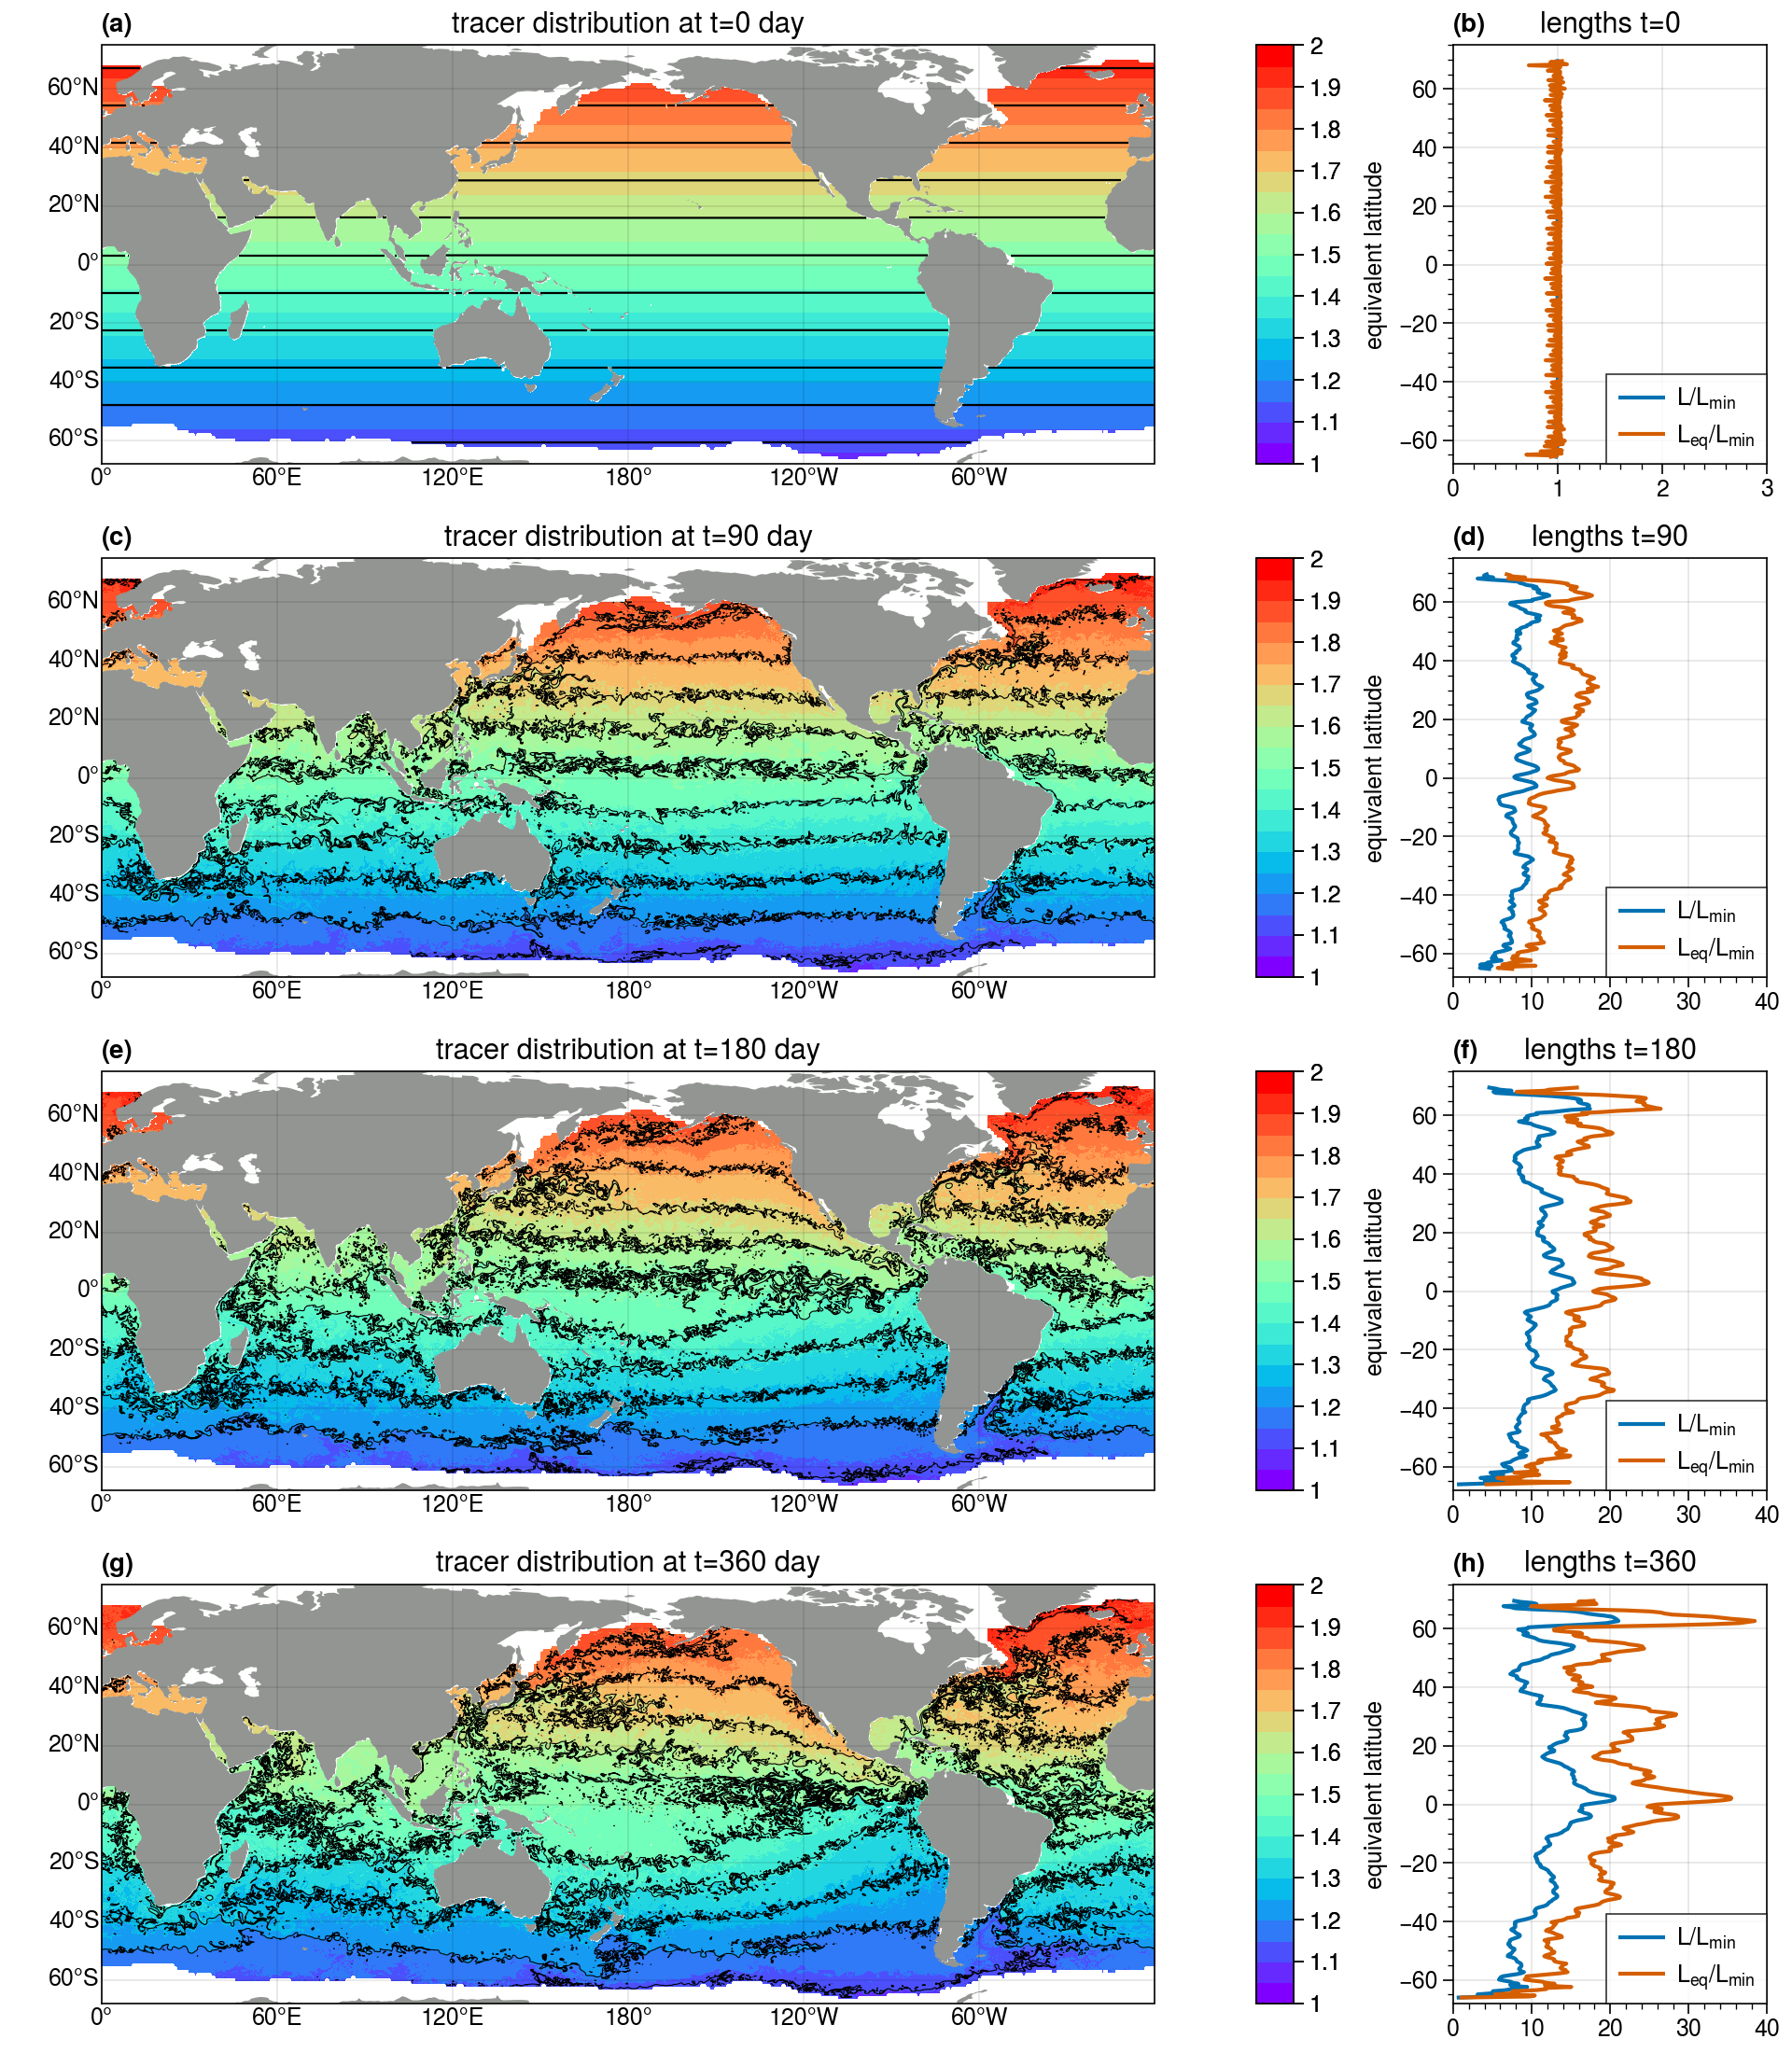

In [5]:
import proplot as pplt

fontsize = 11
array = [[1, 1, 1, 1, 2], [3, 3, 3, 3, 4], [5, 5, 5, 5, 6], [7, 7, 7, 7, 8],]
steps = [0, 90, 270, 360]

fig, axes = pplt.subplots(array, figsize=(9.6, 11), sharex=0, sharey=0, facecolor='w',
                          proj=('cyl',None,'cyl',None,'cyl',None,'cyl',None), proj_kw={'central_longitude':180})

def plot_row(idx, tr, len1, len2, step):
    if idx == 0:
        lw = 0.8
        rng = 3
    else:
        lw = 0.4
        rng = 40
    
    ax = axes[idx]
    m1 = ax.pcolormesh(tr[step], levels=np.linspace(1,2,21), cmap='rainbow', rasterized=True)
    ax.contour(tr[step], levels=11, color='k', lw=lw)
    ax.set_title('tracer distribution at t={0} day'.format(steps[step]), fontsize=fontsize)
    ax.set_ylim([-68, 75])
    ax.format(lonlines=60, latlines=20)
    cb = ax.colorbar(m1, loc='r', label='', ticks=0.1, length=1)
    
    ax = axes[idx+1]
    c1=ax.plot(len1[step], re1.Yeq[step], label='$L/L_{min}$')
    c2=ax.plot(len2[step], re1.Yeq[step], label='$L_{eq}/L_{min}$')
    ax.set_xlim([0, rng])
    ax.set_title('lengths t={0}'.format(steps[step]), fontsize=fontsize)
    ax.set_ylabel('equivalent latitude', fontsize=fontsize-2)
    ax.set_ylim([-68, 75])
    ax.legend([c1,c2], loc='lr', ncols=1)

plot_row(0, tr1, (re1.lengths/re1.Lmin), (np.sqrt(re1.Leq2)/re1.Lmin), 0)
plot_row(2, tr1, (re1.lengths/re1.Lmin), (np.sqrt(re1.Leq2)/re1.Lmin), 1)
plot_row(4, tr1, (re1.lengths/re1.Lmin), (np.sqrt(re1.Leq2)/re1.Lmin), 2)
plot_row(6, tr1, (re1.lengths/re1.Lmin), (np.sqrt(re1.Leq2)/re1.Lmin), 3)

axes.format(abc='(a)', land=True, landcolor='gray', lonlines=60, lonlabels='b', latlines=20, latlabels='l')

It is clear that initially, actual length $L$ and equivalent length $L_{eq}$ are both equal to the minimum possible length $L_{min}$.  This is consistent with the theory.  Later, under the stirring effect of geostrophic eddies at different scales, tracer contours are elongated at different spatial scales (i.e., fractal elongation), generating finescale filaments and fronts.  After one year, tracer contours are almost 10 times longer than the initial ones.  However, $L_{eq}$ is somewhat larger than $L$ once the gradient enhancement is taken into account, but their relative ratio remain almost unchanged.

#### References
1. Haynes, P., and E. Shuckburgh, 2000: [Effective diffusivity as a diagnostic of atmospheric transport 1. Stratosphere](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2000JD900093). *J. Geophys. Res.*, **105**, 22777-22794.
2. Nakamura, N., 1996: [Two-dimensional mixing, edge formation, and permeability diagnosed in an area coordinate](https://journals.ametsoc.org/doi/abs/10.1175/1520-0469%281996%29053%3C1524%3ATDMEFA%3E2.0.CO%3B2). *J. Atmos. Sci.*, **53**, 1524-1537.
3. Lorensen, W. E., and H. E. Cline, 2008: [Marching cubes: A high resolution 3D surface construction algorithm](https://dl.acm.org/doi/10.1145/37402.37422). *ACM SIGGRAPH Computer Graphics*, **21**, 163-169.